In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os

#하이퍼파라미터 및 설정 및 데이터셋 경로 설정
# 데이터셋 경로 설정
data = os.path.abspath("dataset")  # 절대 경로로 변환

#데이터셋 불러오기 (학습,검증 분할)
# 데이터셋 불러오기
train = image_dataset_from_directory(
    data,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(1080,1980),
    batch_size=32,
    shuffle=True
)

val = image_dataset_from_directory(
    data,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(1080,1980),
    batch_size=32,
    shuffle=True
)

"""
#클래스 이름과 클래스 수 확인
class_name=train.class_names
num_classes=len(class_name)
print("클래스 이름:", class_name)
"""
# 이미지를 모델 입력 크기(224, 224)로 리사이즈
def resize_image(image, label):
    image = tf.image.resize(image, (224, 224))  # 원하는 크기로 리사이즈
    return image, label

train = train.map(resize_image)
val = val.map(resize_image)

#2. EfficentNetB4 전처리 적용
preproce_input=tf.keras.applications.efficientnet.preprocess_input
train = train.map(lambda x, y: (preproce_input(x), y))
val = val.map(lambda x, y: (preproce_input(x), y))

AUTOTUNE = tf.data.AUTOTUNE
train = train.cache().prefetch(buffer_size=AUTOTUNE)
val = val.cache().prefetch(buffer_size=AUTOTUNE)

#EfficientNetB4 모델 불러오기(사전 학습 가중치, include_top=False)
base__model=EfficientNetB4(input_shape=(224,224, 3), include_top=False, weights='imagenet')
#처음에는 백본 고정
base__model.trainable=False

#4.새 분류기 구성 및 전체 모델 생성
inputs=tf.keras.Input(shape=(224,224, 3))
x=base__model(inputs, training=False)
x=layers.GlobalAveragePooling2D()(x)
x=layers.Dropout(0.4)(x) #일단 학습 시켜보고 결과 따라서, 일단 EfficientNetB4의 기본 드롭아웃 비율은 0.4, 0.5로 변경해보기
outputs=layers.Dense(32, activation='softmax')(x) #32개로 변경
model=models.Model(inputs, outputs)

#5. 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

#6. 모델 컴파일: 전이 학습 단계
epoch = 10  # 초기 에포크 수
history = model.fit(train, epochs=epoch, validation_data=val)

#7. 파인튜닝 단계: 백본 일부 해제해서 미세 조정
# 백본의 모든 레이어를 훈련 가능하게 변경한 후 , 일부 초기 레이어는 다시 고정
base__model.trainable=True
fine_tune_at=int(len(base__model.layers)*0.8) # 전체 레이어의 80%를 고정

# 낮은 학습률로 재컴파일
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

fine_tune_epochs = 50  # 파인튜닝 에포크 수
total_epochs = epoch + fine_tune_epochs

history_fine = model.fit(train, epochs=total_epochs, initial_epoch=epoch, validation_data=val)

tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir="logs", histogram_freq=1)
# Define the missing callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filepath="model_checkpoint.h5", save_best_only=True)
reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3)
class EpochLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch + 1} ended. Logs: {logs}")

callbacks_list = [checkpoint_cb, reduce_lr_cb, EpochLogger(), tensorboard_cb]


2025-04-05 02:34:13.480888: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-05 02:34:13.500109: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-05 02:34:13.649567: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-05 02:34:13.842904: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743788054.095317    9741 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743788054.16

Found 3930 files belonging to 32 classes.
Using 3144 files for training.


W0000 00:00:1743788066.346911    9741 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Found 3930 files belonging to 32 classes.
Using 786 files for validation.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb4 (Functional)     │ (None, 7, 7, 1792)     │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1792)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1792)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        57,376 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,731,199 (67.64 MB)

 Trainable params: 57,376 (224.12 KB)

 Non-trainable params: 17,673,823 (67.42 MB)

Epoch 1/10


2025-04-05 02:35:05.643274: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 821145728 bytes after encountering the first element of size 821145728 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-04-05 02:35:06.164961: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19267712 bytes after encountering the first element of size 19267712 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


99/99 ━━━━━━━━━━━━━━━━━━━━ 113s 814ms/step - accuracy: 0.1686 - loss: 3.0566 - val_accuracy: 0.3321 - val_loss: 2.2035
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 67s 676ms/step - accuracy: 0.3575 - loss: 2.2028 - val_accuracy: 0.4656 - val_loss: 1.7650
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 67s 680ms/step - accuracy: 0.4550 - loss: 1.8365 - val_accuracy: 0.5165 - val_loss: 1.5215
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 67s 677ms/step - accuracy: 0.5093 - loss: 1.6184 - val_accuracy: 0.5941 - val_loss: 1.3374
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 67s 676ms/step - accuracy: 0.5361 - loss: 1.5068 - val_accuracy: 0.6298 - val_loss: 1.2154
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 67s 675ms/step - accuracy: 0.5835 - loss: 1.3614 - val_accuracy: 0.6985 - val_loss: 1.1118
Epoch 7/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 67s 676ms/step - accuracy: 0.6252 - loss: 1.2660 - val_accuracy: 0.6718 - val_loss: 1.0430
Epoch 8/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 67s 676ms/step - accuracy: 0.6106 - loss: 1.2234 - val_accuracy: 0.71

2025-04-05 11:22:29.321205: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-05 11:22:29.329927: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-05 11:22:29.401944: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-05 11:22:29.457402: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743819749.514246    1818 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743819749.53

Found 3930 files belonging to 32 classes.
Using 3144 files for training.
Found 3930 files belonging to 32 classes.
Using 786 files for validation.


W0000 00:00:1743819752.392865    1818 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 85s 780ms/step - accuracy: 0.1698 - loss: 3.0561 - val_accuracy: 0.3130 - val_loss: 2.2046
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 67s 671ms/step - accuracy: 0.3511 - loss: 2.2151 - val_accuracy: 0.4580 - val_loss: 1.7678
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 66s 671ms/step - accuracy: 0.4503 - loss: 1.8440 - val_accuracy: 0.5229 - val_loss: 1.5252
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 66s 671ms/step - accuracy: 0.5094 - loss: 1.6386 - val_accuracy: 0.5827 - val_loss: 1.3500
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 66s 670ms/step - accuracy: 0.5330 - loss: 1.4798 - val_accuracy: 0.6260 - val_loss: 1.2212
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 67s 673ms/step - accuracy: 0.5967 - loss: 1.3553 - val_accuracy: 0.6399 - val_loss: 1.1267
Epoch 7/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 66s 670ms/step - accuracy: 0.6013 - loss: 1.2777 - val_accuracy: 0.6679 - val_loss: 1.0578
Epoch 8/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 66s 670ms/step - accuracy: 0.6339 - loss: 1.2139 - val_accu

2025-04-05 12:29:46.199895: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


134/134 ━━━━━━━━━━━━━━━━━━━━ 73s 538ms/step
혼동 행렬:
 [[336   0   0 ...   0   0  84]
 [ 26  47   1 ...   0   0   0]
 [  5   0   0 ...  17  19  10]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0  11  13]]
분류 보고서:
               precision    recall  f1-score   support

           0       0.88      0.80      0.84       420
           1       0.87      0.64      0.73        74
           2       0.00      0.00      0.00       144
           3       0.00      0.00      0.00       151
           4       0.00      0.00      0.00        44
           5       0.00      0.00      0.00       172
           6       0.00      0.00      0.00       147
           7       0.00      0.00      0.00        72
           8       0.00      0.00      0.00        87
           9       0.00      0.00      0.00        46
          10       0.00      0.00      0.00       168
          11       0.00      0.00      0.00        76
          12       0.00      0.00      0.00 

/home/rlaskdus/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/rlaskdus/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/rlaskdus/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


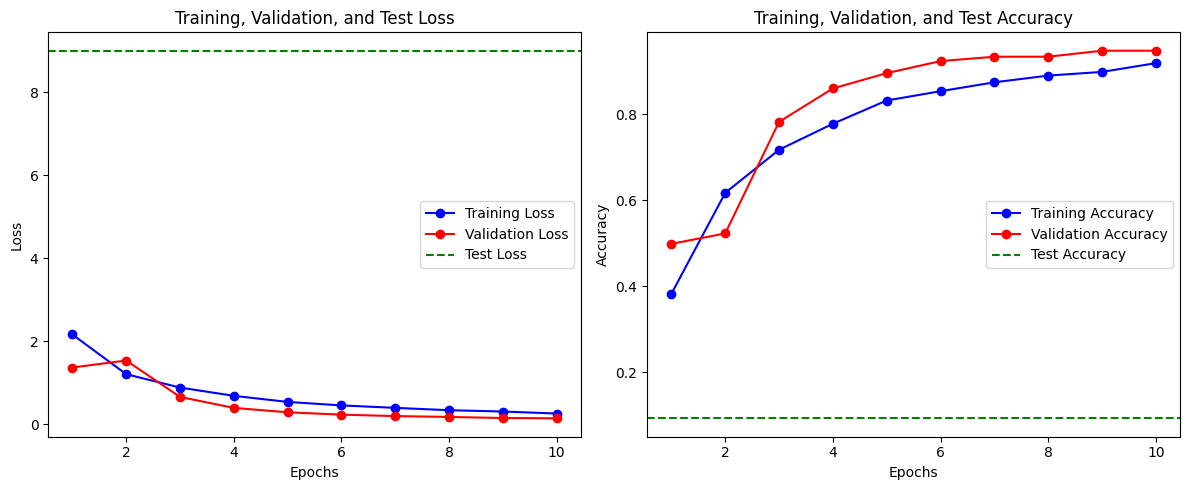

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# 하이퍼파라미터 및 설정
data = os.path.abspath("dataset")  # 학습 데이터 경로
test_data_path = os.path.abspath("유단자A")  # 테스트 데이터 경로

# 데이터셋 불러오기 (학습, 검증)
train = image_dataset_from_directory(
    data,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(1080, 1980),
    batch_size=32,
    shuffle=True
)

val = image_dataset_from_directory(
    data,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(1080, 1980),
    batch_size=32,
    shuffle=True
)

# 이미지 리사이즈 및 전처리 함수
def resize_image(image, label):
    image = tf.image.resize(image, (224, 224))  # 모델 입력 크기로 리사이즈
    return image, label

preproce_input = tf.keras.applications.efficientnet.preprocess_input

# 학습 및 검증 데이터 전처리
train = train.map(resize_image).map(lambda x, y: (preproce_input(x), y)).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val = val.map(resize_image).map(lambda x, y: (preproce_input(x), y)).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# EfficientNetB4 모델 구성
base__model = EfficientNetB4(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base__model.trainable = False  # 백본 고정

inputs = tf.keras.Input(shape=(224, 224, 3))
x = base__model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(32, activation='softmax')(x)
model = models.Model(inputs, outputs)

# 모델 컴파일 및 학습
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train, epochs=10, validation_data=val)

# 파인튜닝
base__model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_fine = model.fit(train, epochs=20, initial_epoch=10, validation_data=val)

# 테스트 데이터셋 불러오기
test = image_dataset_from_directory(
    test_data_path,
    image_size=(1080, 1980),
    batch_size=32,
    shuffle=False
)

# 테스트 데이터 전처리
test = test.map(resize_image).map(lambda x, y: (preproce_input(x), y)).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# 테스트 데이터 평가
test_loss, test_accuracy = model.evaluate(test)
print(f"테스트 손실: {test_loss}")
print(f"테스트 정확도: {test_accuracy}")

# 테스트 데이터 예측 및 분석
y_true = np.concatenate([y for x, y in test], axis=0)  # 실제 레이블
y_pred = np.argmax(model.predict(test), axis=-1)  # 예측 레이블

# 혼동 행렬 및 분류 보고서 출력
cm = confusion_matrix(y_true, y_pred)
print("혼동 행렬:\n", cm)
print("분류 보고서:\n", classification_report(y_true, y_pred))

# 학습, 검증, 테스트 성능 시각화
def plot_training_history(history, test_loss=None, test_accuracy=None):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 5))
    
    # 손실 그래프
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    if test_loss is not None:
        plt.axhline(y=test_loss, color='g', linestyle='--', label='Test Loss')
    plt.title('Training, Validation, and Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 정확도 그래프
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
    if test_accuracy is not None:
        plt.axhline(y=test_accuracy, color='g', linestyle='--', label='Test Accuracy')
    plt.title('Training, Validation, and Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 시각화 호출
plot_training_history(history_fine, test_loss=test_loss, test_accuracy=test_accuracy)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# 데이터셋 경로 설정
data = os.path.abspath("dataset")  # 학습 데이터 경로
test_data_path = os.path.abspath("test_dataset")  # 테스트 데이터 경로

# 데이터셋 불러오기 (학습, 검증)
train = image_dataset_from_directory(
    data,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(1080, 1980),
    batch_size=32,
    shuffle=True
)

val = image_dataset_from_directory(
    data,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(1080, 1980),
    batch_size=32,
    shuffle=True
)

# 이미지 리사이즈 및 전처리 함수
def resize_image(image, label):
    image = tf.image.resize(image, (224, 224))  # 모델 입력 크기로 리사이즈
    return image, label

preproce_input = tf.keras.applications.efficientnet.preprocess_input

# 학습 및 검증 데이터 전처리
train = train.map(resize_image).map(lambda x, y: (preproce_input(x), y)).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val = val.map(resize_image).map(lambda x, y: (preproce_input(x), y)).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# EfficientNetB4 모델 구성
base__model = EfficientNetB4(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base__model.trainable = False  # 백본 고정

inputs = tf.keras.Input(shape=(224, 224, 3))
x = base__model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(32, activation='softmax')(x)
model = models.Model(inputs, outputs)

# 모델 컴파일 및 학습
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train, epochs=10, validation_data=val)

# 파인튜닝
base__model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_fine = model.fit(train, epochs=20, initial_epoch=10, validation_data=val)

# 테스트 데이터셋 불러오기
test = image_dataset_from_directory(
    test_data_path,
    image_size=(1080, 1980),
    batch_size=32,
    shuffle=False
)

# 테스트 데이터 전처리
test = test.map(resize_image).map(lambda x, y: (preproce_input(x), y)).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# 테스트 데이터 평가
test_loss, test_accuracy = model.evaluate(test)
print(f"테스트 손실: {test_loss}")
print(f"테스트 정확도: {test_accuracy}")

# 테스트 데이터 예측 및 분석
y_true = np.concatenate([y for x, y in test], axis=0)  # 실제 레이블
y_pred = np.argmax(model.predict(test), axis=-1)  # 예측 레이블

# 혼동 행렬 및 분류 보고서 출력
cm = confusion_matrix(y_true, y_pred)
print("혼동 행렬:\n", cm)
print("분류 보고서:\n", classification_report(y_true, y_pred))

# 학습, 검증, 테스트 성능 시각화
def plot_training_history(history, history_fine, test_loss=None, test_accuracy=None):
    train_loss = history.history['loss'] + history_fine.history['loss']
    val_loss = history.history['val_loss'] + history_fine.history['val_loss']
    train_accuracy = history.history['accuracy'] + history_fine.history['accuracy']
    val_accuracy = history.history['val_accuracy'] + history_fine.history['val_accuracy']
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 5))
    
    # 손실 그래프
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    if test_loss is not None:
        plt.axhline(y=test_loss, color='g', linestyle='--', label='Test Loss')
    plt.title('Training, Validation, and Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 정확도 그래프
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
    if test_accuracy is not None:
        plt.axhline(y=test_accuracy, color='g', linestyle='--', label='Test Accuracy')
    plt.title('Training, Validation, and Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 시각화 호출
plot_training_history(history, history_fine, test_loss=test_loss, test_accuracy=test_accuracy)

Found 3930 files belonging to 32 classes.
Using 3144 files for training.
Found 3930 files belonging to 32 classes.
Using 786 files for validation.
Epoch 1/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 84s 771ms/step - accuracy: 0.1873 - loss: 3.0469 - val_accuracy: 0.3041 - val_loss: 2.2326
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 67s 681ms/step - accuracy: 0.3672 - loss: 2.1943 - val_accuracy: 0.4644 - val_loss: 1.7848
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 67s 681ms/step - accuracy: 0.4482 - loss: 1.8572 - val_accuracy: 0.5471 - val_loss: 1.5208
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 67s 682ms/step - accuracy: 0.4924 - loss: 1.6509 - val_accuracy: 0.5827 - val_loss: 1.3559
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 68s 687ms/step - accuracy: 0.5418 - loss: 1.4863 - val_accuracy: 0.6196 - val_loss: 1.2302
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 67s 681ms/step - accuracy: 0.5828 - loss: 1.3731 - val_accuracy: 0.6476 - val_loss: 1.1297
Epoch 7/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 67s 680ms/step - accuracy: 0.6018 - loss:

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os

# 테스트 데이터 경로 설정
test_data_path = os.path.abspath("taekwon_form/유단자E")  # 테스트 데이터 경로

# 테스트 데이터셋 불러오기
test_dataset = image_dataset_from_directory(
    test_data_path,
    image_size=(1080, 1980),
    batch_size=32,
    shuffle=False
)

# 클래스 이름 확인
class_names = test_dataset.class_names
print("클래스 이름:", class_names)

# 각 클래스별 데이터 개수 확인
class_counts = {class_name: 0 for class_name in class_names}

for _, labels in test_dataset:
    for label in labels.numpy():
        class_counts[class_names[label]] += 1

print("클래스별 데이터 개수:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")